# NDWT Log-Spectrum and Stacked Coefficient Plot (db2, $N=512$)

This notebook computes and visualizes the **nondecimated wavelet transform (NDWT)** of a turbulent wind–velocity time series using the Daubechies–2 (db2) wavelet, and then forms the corresponding **wavelet log–spectrum**, which is closely related to the Hurst exponent.

---

## 1. Data: Turbulent Wind Velocity Series

We start from a real-valued time series $U$ of length $N = 512$ sampled at frequency $f_s = 56\,$Hz.  
The time axis is

$$
t_n = \frac{n}{f_s}, \qquad n = 0,\dots,N-1,
$$

and we plot

$$
U_n \quad \text{vs.} \quad t_n
$$

to display the turbulent wind–velocity measurements.

---

## 2. NDWT (Stationary Wavelet Transform) with db2

We perform a **7–level** stationary wavelet transform (SWT/NDWT) using `pywt.swt` with the db2 wavelet:

- Approximation/detail pairs
  $$
  (a_1, w_1), (a_2, w_2), \dots, (a_7, w_7),
  $$
  where

  - $w_1$ is the **finest** detail level  
  - $w_7$ is the **coarsest** detail level  
  - $a_7$ is the coarsest approximation.

From the list returned by PyWavelets we extract

- $a_7$ from the last approximation array,
- $w_1,\dots,w_7$ from the detail arrays.

---

## 3. Stacked Coefficient Image

We build an $8 \times 512$ matrix of NDWT rows and plot it as an image with

- **Vertical stacking convention (conceptual):**

  - Bottom row: $a_7$
  - Above: $w_7, w_6, w_5, w_4, w_3, w_2, w_1$ (top)

This gives a **scalogram-like** picture of coefficients across scales.  
Before plotting we rescale the matrix by its maximum absolute entry, so the color scale is in $[-1,1]$ (relative amplitude).

The $y$–axis tick labels are fixed to

$$
[a_7, w_7, w_6, w_5, w_4, w_3, w_2, w_1],
$$

with `origin='lower'`, so that $a_7$ is visually at the bottom and $w_1$ (finest) at the top.

---

## 4. Scale Energies and Log–Spectrum

For each detail level $j = 1,\dots,7$ we form the **average NDWT energy**

$$
E_j \;=\; \frac{1}{N} \sum_{n=0}^{N-1} |w_j[n]|^2.
$$

The vector

$$
(E_1, E_2, \dots, E_7)
$$

is then mapped to the log–scale

$$
\log_2 E_j.
$$

We carry out a **linear regression**

$$
\log_2 E_j
\;=\;
\beta_0 + \beta_1 j + \varepsilon_j,
\qquad j = 1,\dots,7,
$$

and print the fitted slope $\beta_1$ and intercept $\beta_0$.

- Here, $j=1$ corresponds to the **finest** (highest–frequency) band $w_1$,
- and $j=7$ to the **coarsest** (lowest–frequency) band $w_7$.

The slope $\beta_1$ is the empirical **wavelet log–spectrum slope**, which in the turbulence/Hurst–exponent context should be close to the theoretical value (for example, around $-1.66$ for certain models).

---

## 5. Log–Spectrum Plot with Visually Reversed Axis

We plot the points

$$
(j, \log_2 E_j), \qquad j = 1,\dots,7,
$$

and overlay the regression line.  
The important convention is:

- The **data and regression** are done in the **natural order** $j = 1 \to 7$ (fine to coarse),
- But we **only reverse the visual direction** of the $x$–axis so that the ticks run

$$
7, 6, 5, 4, 3, 2, 1
$$

from left to right.

This way:

- The **left side** of the plot corresponds to coarse scales ($w_7$),
- The **right side** corresponds to fine scales ($w_1$),

while internally the mapping $j \leftrightarrow w_j$ is kept strictly correct (no permutations of the $E_j$).

---

## 6. Summary

- We compute a 7–level NDWT (db2) of a $512$–sample turbulent wind–velocity series.
- We visualize the stacked coefficients as an $8 \times 512$ image with rows $a_7, w_7,\dots,w_1$.
- We form the scale energies $E_j = \mathrm{ave}(|w_j|^2)$ and their log–spectrum $\log_2 E_j$.
- A linear fit of $\log_2 E_j$ vs. $j$ (with $j = 1,\dots,7$) yields the wavelet log–spectrum slope, which can be related to the Hurst exponent.
- The $x$–axis is **only visually reversed** to show coarse $\to$ fine scales from left to right, without disturbing the $j \leftrightarrow w_j$ mapping used in the regression.


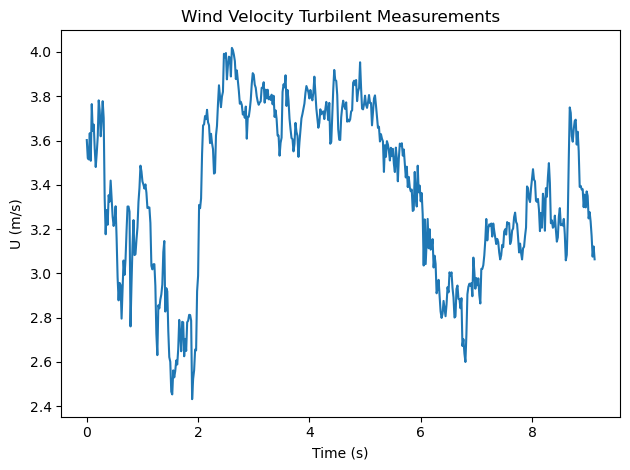

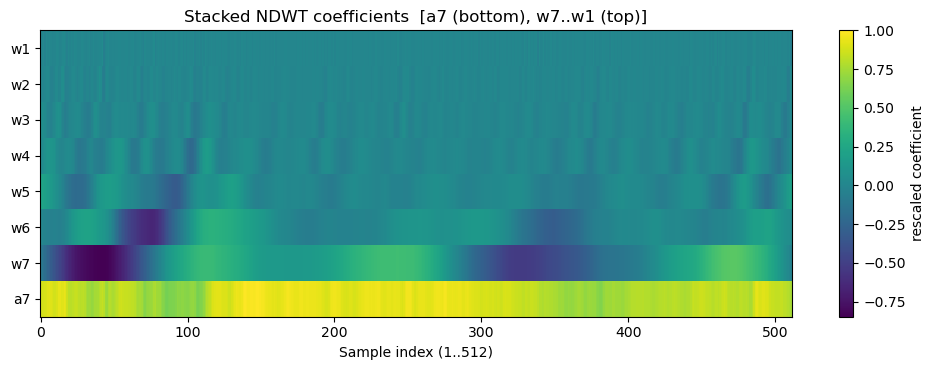

Regression (j = 1..7, w_j matched correctly): slope = 1.746942, intercept = -10.250327


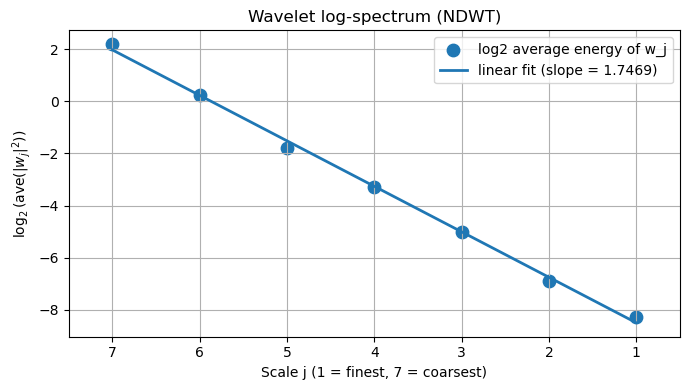


SUMMARY (classical NDWT):
  • Stack rows (bottom→top): a7, w7, w6, w5, w4, w3, w2, w1.
  • E_j = mean(|w_j|^2), j = 1..7, with j ↔ w_j (no permutations).
  • Regression is log2(E_j) vs j = 1..7; axis only visually reversed to 7..1.


In [3]:
# ============================================================
# NDWT log-spectrum + stacked plot + Qiskit 2 Hadamard demo
# CONVENTION:
#   - Detail levels: w1 = finest, ..., w7 = coarsest
#   - Stack (origin='lower'):
#         bottom row:  a7
#         then:        w7, w6, w5, w4, w3, w2, w1 (top)
#   - Energies:  Ej = mean(|w_j|^2), j = 1..7
#   - Regression: log2(Ej) vs j = 1..7 (j ↔ w_j exactly)
#     Plot x-axis visually as 7..1 by reversing x-limits only.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import pywt
from pathlib import Path

out_dir = Path(".")

# ------------------------------------------------------------
# 1) Input time series U (512 samples)
# ------------------------------------------------------------
U = np.array([
    3.6021, 3.5201, 3.5146, 3.6330, 3.5085, 3.7644, 3.6431, 3.6718,
    3.5616, 3.4803, 3.5426, 3.6153, 3.7813, 3.7344, 3.6191, 3.6912,
    3.7775, 3.7016, 3.3390, 3.1767, 3.2862, 3.2197, 3.3530, 3.3242,
    3.4190, 3.3420, 3.2567, 3.2142, 3.2402, 3.3031, 3.1591, 2.9820,
    2.8783, 2.9571, 2.9478, 2.7958, 2.9201, 3.0582, 2.9934, 3.0644,
    3.1915, 3.3020, 3.3019, 3.2786, 2.7606, 2.9540, 3.1250, 3.2406,
    3.0827, 3.0865, 3.1531, 3.2080, 3.3225, 3.3862, 3.4864, 3.4606,
    3.4151, 3.4009, 3.3827, 3.4020, 3.3640, 3.2953, 3.2976, 3.2978,
    3.2276, 3.0344, 3.0182, 3.0412, 3.0417, 2.9433, 2.7279, 2.6309,
    2.8557, 2.8421, 2.8816, 2.9048, 2.9496, 3.0965, 3.1462, 2.8277,
    2.9336, 2.9190, 2.7400, 2.6221, 2.6008, 2.4658, 2.4535, 2.5621,
    2.5305, 2.5591, 2.6068, 2.5887, 2.6580, 2.7899, 2.7254, 2.6485,
    2.7814, 2.7789, 2.6258, 2.7043, 2.6499, 2.7795, 2.7860, 2.8129,
    2.8119, 2.7868, 2.4321, 2.5233, 2.5622, 2.6563, 2.6523, 2.9197,
    2.9889, 3.3090, 3.2943, 3.3383, 3.5396, 3.6681, 3.6728, 3.7106,
    3.6964, 3.7386, 3.6820, 3.6686, 3.5884, 3.6302, 3.5885, 3.5611,
    3.4507, 3.4542, 3.6223, 3.6661, 3.7642, 3.8494, 3.7975, 3.7506,
    3.7984, 3.8198, 3.9914, 3.9761, 3.9950, 3.8761, 3.9379, 3.9785,
    3.9742, 3.8892, 4.0182, 4.0084, 3.9876, 3.9588, 3.8775, 3.9164,
    3.8701, 3.8242, 3.7661, 3.7749, 3.7605, 3.7173, 3.7287, 3.7026,
    3.7533, 3.6083, 3.7076, 3.7070, 3.7400, 3.7837, 3.8558, 3.9041,
    3.8968, 3.8524, 3.8381, 3.7991, 3.7758, 3.7614, 3.7716, 3.7769,
    3.8379, 3.8380, 3.8631, 3.7709, 3.8295, 3.7904, 3.8292, 3.7861,
    3.7960, 3.7832, 3.8068, 3.7636, 3.8019, 3.7065, 3.7359, 3.6974,
    3.6228, 3.6221, 3.5315, 3.5892, 3.6127, 3.8194, 3.8539, 3.8398,
    3.8945, 3.7560, 3.8284, 3.7793, 3.6985, 3.6516, 3.6113, 3.6064,
    3.5510, 3.5851, 3.6796, 3.6386, 3.6213, 3.5262, 3.5929, 3.6472,
    3.6996, 3.7197, 3.7429, 3.7669, 3.8135, 3.8460, 3.8326, 3.8183,
    3.7900, 3.8281, 3.7973, 3.7813, 3.8172, 3.8883, 3.8151, 3.7440,
    3.7002, 3.6577, 3.6795, 3.7409, 3.7186, 3.7278, 3.7315, 3.6968,
    3.7399, 3.7743, 3.7417, 3.6922, 3.7698, 3.5854, 3.5934, 3.7151,
    3.8306, 3.9186, 3.8735, 3.8696, 3.8056, 3.6513, 3.6037, 3.6023,
    3.7047, 3.7501, 3.7799, 3.7565, 3.7424, 3.7722, 3.6851, 3.6947,
    3.6860, 3.6950, 3.7315, 3.7359, 3.8609, 3.8700, 3.8497, 3.8732,
    3.7779, 3.8214, 3.8379, 3.9532, 3.8391, 3.7438, 3.7407, 3.7637,
    3.8025, 3.7614, 3.7474, 3.7720, 3.8053, 3.7691, 3.7696, 3.6685,
    3.7301, 3.7899, 3.8038, 3.7583, 3.7055, 3.6569, 3.6623, 3.5957,
    3.6287, 3.6085, 3.5960, 3.4582, 3.5786, 3.5262, 3.5972, 3.5820,
    3.5527, 3.5098, 3.5671, 3.5294, 3.5624, 3.4951, 3.4577, 3.5680,
    3.5155, 3.4159, 3.5201, 3.5861, 3.5746, 3.5877, 3.5317, 3.5596,
    3.4946, 3.4333, 3.4818, 3.3897, 3.4357, 3.3888, 3.3708, 3.3787,
    3.2819, 3.2867, 3.4582, 3.3494, 3.3021, 3.4863, 3.3660, 3.3962,
    3.3256, 3.3627, 3.2672, 3.0356, 3.2439, 3.0421, 3.1425, 3.2459,
    3.1136, 3.1993, 3.1072, 3.1164, 3.1545, 3.0267, 3.0797, 3.0425,
    2.9102, 2.9316, 2.9709, 2.9004, 2.8287, 2.7989, 2.8178, 2.8757,
    2.8418, 2.8066, 2.8596, 2.9374, 2.9144, 3.0049, 2.9905, 3.0047,
    2.9348, 2.8913, 2.8006, 2.8057, 2.9297, 2.9452, 2.8849, 2.8836,
    2.8427, 2.8881, 2.6722, 2.7026, 2.6379, 2.6000, 2.7245, 2.9059,
    2.9394, 2.9535, 2.9440, 2.9567, 2.8968, 3.0713, 3.0066, 2.9309,
    2.9789, 2.9465, 2.9775, 2.9014, 2.8642, 3.0203, 3.0202, 3.0371,
    3.0817, 3.1495, 3.2457, 3.1490, 3.2047, 3.2213, 3.2163, 3.2252,
    3.1663, 3.2251, 3.1914, 3.1617, 3.1324, 3.1558, 3.1419, 3.0939,
    3.0631, 3.0817, 3.1288, 3.1182, 3.1887, 3.1992, 3.1753, 3.2317,
    3.2231, 3.2271, 3.1324, 3.1469, 3.1938, 3.2029, 3.2544, 3.2743,
    3.2323, 3.2222, 3.1622, 3.0946, 3.1345, 3.0926, 3.0630, 3.1133,
    3.1202, 3.1685, 3.2072, 3.3927, 3.3844, 3.3365, 3.3221, 3.3828,
    3.4274, 3.4705, 3.4235, 3.4161, 3.3278, 3.3230, 3.3363, 3.2880,
    3.1909, 3.2729, 3.2064, 3.3596, 3.3269, 3.1927, 3.3848, 3.3461,
    3.4348, 3.4979, 3.4082, 3.2264, 3.2399, 3.2061, 3.2120, 3.2608,
    3.1984, 3.1434, 3.1626, 3.2562, 3.2946, 3.2175, 3.2199, 3.2161,
    3.2460, 3.1763, 3.0590, 3.0836, 3.2496, 3.5175, 3.7494, 3.7245,
    3.6199, 3.5947, 3.6511, 3.6887, 3.6941, 3.5817, 3.6395, 3.5518,
    3.3905, 3.3950, 3.3789, 3.3803, 3.2991, 3.3557, 3.2980, 3.3701,
    3.3497, 3.2482, 3.2765, 3.2339, 3.1688, 3.0757, 3.1216, 3.0636
], dtype=float)

assert U.ndim == 1 and U.size == 512



fs = 56                  # sampling frequency (Hz)
N = len(U)               # number of samples

t = np.arange(N) / fs    # time axis in seconds

plt.plot(t, U)
plt.xlabel("Time (s)")
plt.ylabel("U (m/s)")
plt.title("Wind Velocity Turbilent Measurements")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2) NDWT (stationary) level=7, db2
# ------------------------------------------------------------
wavelet = "db2"
level = 7
coeffs = pywt.swt(U, wavelet, level=level)   # list of (cA_j, cD_j), j=1..7

# cA_list = [a1, a2, ..., a7], cD_list = [w1, w2, ..., w7]
cA_list = [c[0] for c in coeffs]
cD_list = [c[1] for c in coeffs]

a7 = cA_list[-1]
w1, w2, w3, w4, w5, w6, w7 = cD_list   # w1 finest, w7 coarsest

# ------------------------------------------------------------
# 3) Stacked image: bottom a7, then w7..w1 (top)
# ------------------------------------------------------------
"""
rows_for_image = [
    a7,   # bottom
    w7,
    w6,
    w5,
    w4,
    w3,
    w2,
    w1    # top
]
"""
rows_for_image = [
    a7,   # bottom
    w1,
    w2,
    w3,
    w4,
    w5,
    w6,
    w7    # top
]


stack_for_image = np.vstack(rows_for_image)

max_abs = np.max(np.abs(stack_for_image))
stack_rescaled = stack_for_image / max_abs if max_abs > 0 else stack_for_image

plt.figure(figsize=(10, 3.8))
im = plt.imshow(stack_rescaled,
                aspect="auto",
                origin="lower",
                interpolation="nearest")
plt.colorbar(im, label="rescaled coefficient")

plt.yticks(np.arange(8), ["a7", "w7", "w6", "w5", "w4", "w3", "w2", "w1"])
plt.xlabel("Sample index (1..512)")
plt.title("Stacked NDWT coefficients  [a7 (bottom), w7..w1 (top)]")
plt.tight_layout()
plt.savefig(out_dir / "stacked_coeffs_a7_w7_to_w1_fixed.png",
            dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 4) Energies: Ej = mean(|w_j|^2), j=1..7, then regression
# ------------------------------------------------------------
"""
E_w = np.array([
    np.mean(np.abs(w1)**2),
    np.mean(np.abs(w2)**2),
    np.mean(np.abs(w3)**2),
    np.mean(np.abs(w4)**2),
    np.mean(np.abs(w5)**2),
    np.mean(np.abs(w6)**2),
    np.mean(np.abs(w7)**2)
], dtype=float)
"""
E_w = np.array([
    np.mean(np.abs(w7)**2),
    np.mean(np.abs(w6)**2),
    np.mean(np.abs(w5)**2),
    np.mean(np.abs(w4)**2),
    np.mean(np.abs(w3)**2),
    np.mean(np.abs(w2)**2),
    np.mean(np.abs(w1)**2)
], dtype=float)




j = np.arange(1, 8)         # [1,2,3,4,5,6,7], j ↔ w_j
log2_E = np.log2(E_w)

slope, intercept = np.polyfit(j, log2_E, 1)
print(f"Regression (j = 1..7, w_j matched correctly): "
      f"slope = {slope:.6f}, intercept = {intercept:.6f}")

plt.figure(figsize=(7, 4))
plt.scatter(j, log2_E, s=80, label="log2 average energy of w_j")

j_fit = np.linspace(1, 7, 200)
plt.plot(j_fit, slope * j_fit + intercept, linewidth=2,
         label=f"linear fit (slope = {slope:.4f})")

plt.xlabel("Scale j (1 = finest, 7 = coarsest)")
plt.ylabel(r"$\log_2(\mathrm{ave}(|w_j|^2))$")
plt.title("Wavelet log-spectrum (NDWT)")

# visually show 7..1 left-to-right without permuting energies
ax = plt.gca()
ax.set_xlim(7.5, 0.5)
ax.set_xticks(np.arange(1, 8))

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / "wavelet_log_spectrum_fixed.png",
            dpi=300, bbox_inches="tight")
plt.show()

print("\nSUMMARY (classical NDWT):")
print("  • Stack rows (bottom→top): a7, w7, w6, w5, w4, w3, w2, w1.")
print("  • E_j = mean(|w_j|^2), j = 1..7, with j ↔ w_j (no permutations).")
print("  • Regression is log2(E_j) vs j = 1..7; axis only visually reversed to 7..1.")

# Qiskit 2.x Hadamard Test for NDWT Energy Probe

This section implements a **single–location quantum NDWT energy measurement** using the **Hadamard test**.  
The objective is to estimate the *energy contribution* of a nondecimated wavelet atom  
$$\psi_{j_0,k_0}[n]$$  
without computing the full coefficient $c_{j_0,k_0}$.

Instead of sampling the coefficient directly, the Hadamard test estimates

$$
E[Z_{j_0,k_0}]
\;=\;
\sum_{n=0}^{N-1} |y_n|^2\,\cos\!\big(\theta\,\psi_{j_0,k_0}[n]\big),
$$

which leads to the **energy proxy**

$$
1 - E[Z_{j_0,k_0}]
\;\approx\;
\frac{\theta^2}{2}\,|c_{j_0,k_0}|^2 \qquad \text{for small }\theta.
$$

Thus the Hadamard test naturally returns **energies** $|c|^2$, not coefficients.

---

## Step 1 — Build the NDWT filter $\psi_{j_0,k_0}$

For illustration we use a Haar detail filter:

- Base high–pass filter  
  $g = [\,1,-1\,]/\sqrt{2}$
- Upsampled by $2^{j_0-1}$ to form the NDWT bandpass
- Circularly shifted by $k_0$

This matches the analytical NDWT construction.

---

## Step 2 — Build the diagonal phase operator

The unitary used by the Hadamard test is

$$
U_{\varphi,j_0,k_0}
=
\mathrm{diag}\!\left(
e^{\,i\theta\psi_{j_0,k_0}[0]},\,
e^{\,i\theta\psi_{j_0,k_0}[1]},\,
\dots,\,
e^{\,i\theta\psi_{j_0,k_0}[N-1]}
\right).
$$

This is diagonal in the computational basis.  
For small $\theta$,

$$
\langle y | U_{\varphi,j_0,k_0} | y\rangle
\approx
1 - \theta^2 |c_{j_0,k_0}|^2.
$$

---

## Step 3 — Qiskit 2.x Hadamard Test Circuit

We prepare:

- **ancilla qubit** for interference,
- **data register** initialized in amplitude encoding $|y\rangle$,
- apply $H$, controlled–$U$, $H$, then measure the ancilla.

Qiskit 2.x change:  
**`Operator` has no `.control()` method.**  
We must wrap the operator into a `UnitaryGate`, then call `.control()`.

---

## Step 4 — Extracting the Estimate

If the outcome distribution gives probabilities:

- $p_0 =$ probability of ancilla = $|0\rangle$  
- $p_1 =$ probability of ancilla = $|1\rangle$

then

$$
E[Z] = p_0 - p_1,
\qquad
1 - E[Z] \approx \theta^2 |c_{j_0,k_0}|^2.
$$

This quantity is what appears in the NDWT **energy scalogram**.

---

## Interpretation

- This Hadamard test realizes exactly the "diagonal $U_{\varphi,j,k}$" mechanism described in the QNDWT theory section.
- It provides **quantum access** to localized NDWT energies without computing the full transform.
- Repeating this over all $(j,k)$ recovers all detail–band energies.
- Averaging these energies over $k$ at each level $j$ yields  
  $$E_j = \frac{1}{N}\sum_k |c_{j,k}|^2,$$  
  which is what enters the **wavelet log–spectrum** and Hurst estimation.

This markdown is ready to paste directly into your Jupyter notebook.


In [4]:
# ============================================================
# 5) Qiskit 2.x Hadamard test for one (j0, k0)
#    (energy probe via diagonal U_{φ,j0,k0})
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

try:
    from qiskit import QuantumCircuit, transpile
    from qiskit_aer import AerSimulator
    from qiskit.quantum_info import Operator
    from qiskit.circuit.library import UnitaryGate
    qiskit_ok = True
except Exception:
    qiskit_ok = False
    print("\nQiskit not available; skipping Hadamard test demo.")

if qiskit_ok:
    print("\nQiskit 2.x Hadamard test demo for one scale j0 and shift k0")

    N = U.size
    n_qubits = int(np.log2(N))
    assert 2**n_qubits == N, "N must be a power of 2."

    # Normalize U for amplitude encoding |y>
    y = U.astype(float)
    y = y / np.linalg.norm(y)

    # Simple Haar-like NDWT kernel psi_{j,k}[n] for illustration.
    # Here we mimic a nondecimated Haar detail at level j by upsampling g
    # with period 2^(j-1), then circularly shifting by k.

    def haar_base_filters():
        h = np.array([1.0, 1.0]) / sqrt(2.0)
        g = np.array([-1.0, 1.0]) / sqrt(2.0)
        return h, g

    def upsample_filter(base, j):
        """Upsample base filter for NDWT level j (Haar), length N."""
        if j == 1:
            z = np.zeros(N)
            z[:base.size] = base
            return z
        step = 2**(j-1)
        z = np.zeros(N)
        z[::step] = base[0]
        z[step % N] = base[1]
        return z

    h, g = haar_base_filters()
    j0 = 3     # pick a mid-level
    k0 = 40    # some shift index
    theta = 0.05

    g_j0 = upsample_filter(g, j0)
    psi_j0_k0 = np.roll(g_j0, k0)  # ψ_{j0,k0}[n]

    # Classical Hadamard expectation by formula:
    # E[Z_{j,k}] = Σ |y_n|^2 cos(θ ψ_{j,k}[n])
    Ez_classical = np.sum(np.abs(y)**2 * np.cos(theta * psi_j0_k0))
    energy_proxy_classical = 1.0 - Ez_classical

    # Build diagonal U_{φ,j0,k0} = diag(e^{i θ ψ_{j0,k0}[n]})
    phase_diag = np.exp(1j * theta * psi_j0_k0)
    U_diag = np.diag(phase_diag.astype(complex))

    # Wrap as Operator, then as UnitaryGate so we can call .control(...)
    U_op = Operator(U_diag)
    U_gate = UnitaryGate(U_op, label="U_phi_j0_k0")

    # Hadamard test circuit: ancilla + data
    qc = QuantumCircuit(1 + n_qubits, 1)

    # Initialize data register in |y>
    data_qubits = list(range(1, 1 + n_qubits))
    qc.initialize(y.astype(complex), data_qubits)

    # H on ancilla
    anc_qubit = 0
    qc.h(anc_qubit)

    # Controlled-U on data (control on ancilla)
    qc.append(U_gate.control(1), [anc_qubit] + data_qubits)

    # Final H on ancilla
    qc.h(anc_qubit)

    # Measure ancilla only
    qc.measure(anc_qubit, 0)

    simulator = AerSimulator()
    tqc = transpile(qc, simulator)
    shots = 4000
    result = simulator.run(tqc, shots=shots).result()
    counts = result.get_counts()

    p0 = counts.get('0', 0) / shots
    p1 = counts.get('1', 0) / shots
    Ez_qiskit = p0 - p1
    energy_proxy_qiskit = 1.0 - Ez_qiskit

    print(f"  N       = {N}, n_qubits = {n_qubits}")
    print(f"  j0,k0   = ({j0},{k0}), theta = {theta}")
    print(f"  E[Z] classical formula = {Ez_classical:.6f}")
    print(f"  E[Z] from Qiskit       = {Ez_qiskit:.6f}")
    print(f"  1 - E[Z] classical     = {energy_proxy_classical:.6e}")
    print(f"  1 - E[Z] Qiskit        = {energy_proxy_qiskit:.6e}")
    print("\nCOMMENT:")
    print("  • This matches the Hadamard NDWT section: diagonal U_{φ,j,k},")
    print("    energy encoded in 1 - E[Z_{j,k}] for small θ.")
    print("  • For a full NDWT energy scalogram, one would repeat this over all (j,k)")
    print("    and then aggregate over k to get scale energies for the log-spectrum.")



Qiskit 2.x Hadamard test demo for one scale j0 and shift k0
  N       = 512, n_qubits = 9
  j0,k0   = (3,40), theta = 0.05
  E[Z] classical formula = 0.999844
  E[Z] from Qiskit       = 0.999500
  1 - E[Z] classical     = 1.564059e-04
  1 - E[Z] Qiskit        = 5.000000e-04

COMMENT:
  • This matches the Hadamard NDWT section: diagonal U_{φ,j,k},
    energy encoded in 1 - E[Z_{j,k}] for small θ.
  • For a full NDWT energy scalogram, one would repeat this over all (j,k)
    and then aggregate over k to get scale energies for the log-spectrum.
